In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [ ]:
paths = []
labels = []
for dirname, _, filenames in os.walk('/shemoo'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))
        label = filename.split('_')[-1]
        label = label.split('.')[0]
        label = label[3]
        labels.append(label.lower())
    if len(paths) == 2800:
        break
print('Dataset is Loaded')

Dataset is Loaded


In [ ]:
len(paths)

3000

In [ ]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()

,speech,label
0,/content/drive/MyDrive/shemoo/M21H01.wav,h
1,/content/drive/MyDrive/shemoo/M21H02.wav,h
2,/content/drive/MyDrive/shemoo/M21N01.wav,n
3,/content/drive/MyDrive/shemoo/M21N02.wav,n
4,/content/drive/MyDrive/shemoo/M21N03.wav,n


In [ ]:
df['label'].value_counts()

a    1059
n    1028
s     449
w     225
h     201
f      38
Name: label, dtype: int64

In [ ]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [ ]:
extract_mfcc(df['speech'][0])


array([-241.51698   ,  130.3372    ,   -9.416664  ,   22.208593  ,
         -5.906415  ,    3.7548785 ,   -5.2963343 ,   -6.946368  ,
         -5.3799953 ,    6.203915  ,   -8.437343  ,   15.471336  ,
         -9.110797  ,  -10.802973  ,   -6.053553  ,   -0.61297476,
        -21.904572  ,   -1.7526277 ,  -13.754775  ,    0.73173904,
         -6.5641656 ,   -4.7462    ,   -5.1405506 ,   -1.8739208 ,
         -7.462432  ,    2.1737986 ,  -15.807067  ,    2.2865257 ,
         -4.4737883 ,   -6.8970346 ,    0.6962112 ,   -0.51867336,
         -1.5573114 ,    1.1672937 ,   -2.3438761 ,    3.31998   ,
         -4.647369  ,    4.49429   ,   -2.2940843 ,   -0.8954291 ],
      dtype=float32)

In [ ]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))

In [ ]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(3000, 40)

In [ ]:
X = np.expand_dims(X, -1)
X.shape

(3000, 40, 1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [ ]:
y = y.toarray()

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               264192    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                

In [ ]:
from sklearn.utils import shuffle

X_shuffled, y_shuffled = shuffle(X, y)

In [ ]:
history = model.fit(X_shuffled, y_shuffled, validation_split=0.3, epochs=50, batch_size=64)

Epoch 1/50
33/33 [==============================] - 0s 12ms/step - loss: 0.0034 - accuracy: 0.9986 - val_loss: 1.1967 - val_accuracy: 0.8756
Epoch 2/50
33/33 [==============================] - 0s 9ms/step - loss: 0.0033 - accuracy: 0.9986 - val_loss: 1.2078 - val_accuracy: 0.8722
Epoch 3/50
33/33 [==============================] - 0s 9ms/step - loss: 0.0035 - accuracy: 0.9986 - val_loss: 1.1926 - val_accuracy: 0.8733
Epoch 4/50
33/33 [==============================] - 0s 9ms/step - loss: 0.0039 - accuracy: 0.9976 - val_loss: 1.1868 - val_accuracy: 0.8756
Epoch 5/50
33/33 [==============================] - 0s 8ms/step - loss: 0.0038 - accuracy: 0.9986 - val_loss: 1.2331 - val_accuracy: 0.8744
Epoch 6/50
33/33 [==============================] - 0s 8ms/step - loss: 0.0072 - accuracy: 0.9976 - val_loss: 1.3169 - val_accuracy: 0.8711
Epoch 7/50
33/33 [==============================] - 0s 8ms/step - loss: 0.1165 - accuracy: 0.9733 - val_loss: 1.2693 - val_accuracy: 0.8411
Epoch 8/50
33/33 [=

In [ ]:
np.mean(history.history['val_accuracy'])

0.8512444460391998

In [ ]:
np.mean(history.history['accuracy'])

0.9921904826164245

In [ ]:
model.save("/content/drive/MyDrive/SER/model/bestlstm.h5")

In [ ]:
from keras.models import load_model
loaded_model = load_model("/content/drive/MyDrive/shemo.h5")

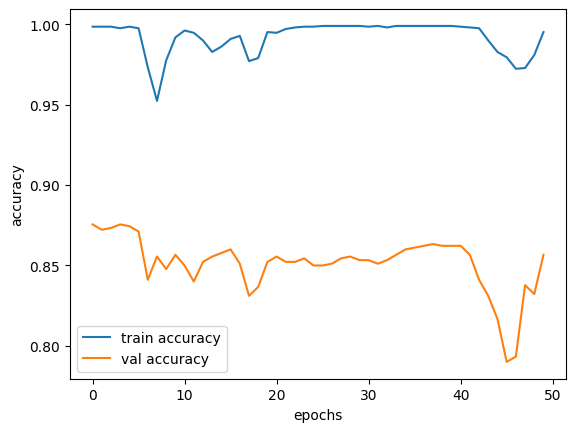

In [ ]:
epochs = list(range(50))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

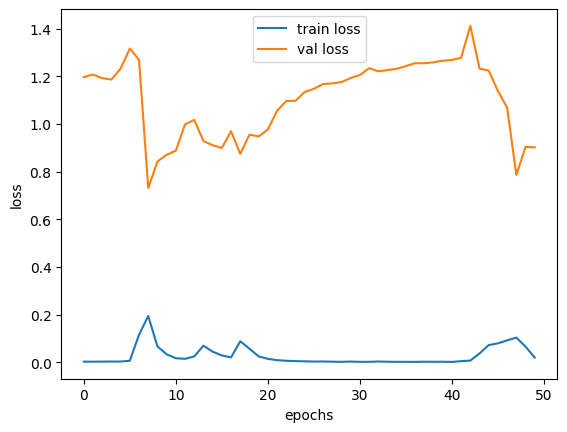

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
import pickle
import keras
from keras import layers, Sequential
from keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.utils import np_utils
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics

In [ ]:
def extract_feature(data, sr, mfcc, chroma, mel):


    if chroma:
        stft = np.abs(librosa.stft(data))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T,axis=0)
        result = np.hstack((result, mel))

    return result

In [ ]:
def noise(data, noise_factor):

    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise

    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [ ]:
def shift(data, sampling_rate, shift_max, shift_direction):


    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0

    return augmented_data

In [ ]:
def load_data(save=False):


    x, y = [], []
    for file in glob.glob('shemoo/' + "*.wav"):
        data, sr = librosa.load(file)

        feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        file_name = os.path.basename(file)
        emotion = file_name[3]

        y.append(emotion)
        n_data = noise(data, 0.001)
        n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(n_feature)
        y.append(emotion)
        s_data = shift(data,sr,0.25,'right')
        s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(s_feature)
        y.append(emotion)

    if save==True:
        np.save('X', np.array(x))
        np.save('y', y)

    print(np.array(x))
    print(y)
    return np.array(x), y

In [ ]:
X, y = load_data(save=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=9)

In [ ]:
from keras.optimizers import Adam
model = Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=8,
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)
                )
)
model.add(Activation('softmax'))

In [ ]:
op=keras.optimizers.Adam(decay=1e-6)


In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=op,metrics=['accuracy'])

In [ ]:
XProccessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)
history = model.fit(XProccessed, y_train, epochs=50, validation_data=(XTestProcessed, y_test), batch_size=64)

Epoch 1/50
127/127 [==============================] - 1s 10ms/step - loss: 0.2373 - accuracy: 0.9804 - val_loss: 0.2939 - val_accuracy: 0.9744
Epoch 2/50
127/127 [==============================] - 1s 9ms/step - loss: 0.2439 - accuracy: 0.9788 - val_loss: 0.2821 - val_accuracy: 0.9700
Epoch 3/50
127/127 [==============================] - 1s 9ms/step - loss: 0.2755 - accuracy: 0.9678 - val_loss: 0.3116 - val_accuracy: 0.9656
Epoch 4/50
127/127 [==============================] - 1s 10ms/step - loss: 0.2779 - accuracy: 0.9699 - val_loss: 0.2743 - val_accuracy: 0.9700
Epoch 5/50
127/127 [==============================] - 1s 10ms/step - loss: 0.2492 - accuracy: 0.9757 - val_loss: 0.2977 - val_accuracy: 0.9633
Epoch 6/50
127/127 [==============================] - 1s 10ms/step - loss: 0.2762 - accuracy: 0.9678 - val_loss: 0.3316 - val_accuracy: 0.9622
Epoch 7/50
127/127 [==============================] - 1s 10ms/step - loss: 0.2698 - accuracy: 0.9720 - val_loss: 0.3016 - val_accuracy: 0.9711
E

In [ ]:
np.mean(history.history['val_accuracy'])

0.9763111138343811

In [ ]:
history.history['accuracy']

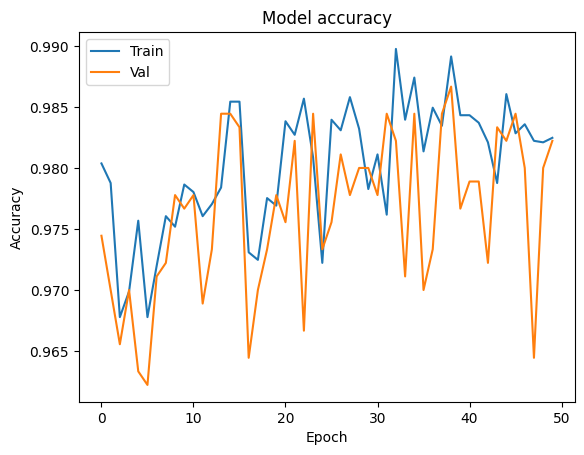

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

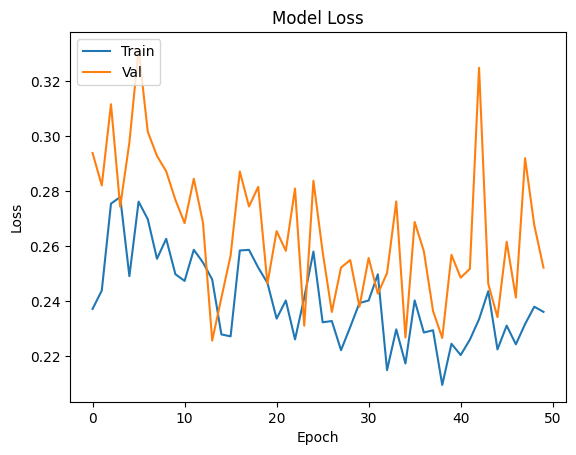

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(XTestProcessed)

29/29 [==============================] - 0s 2ms/step


<Axes: >

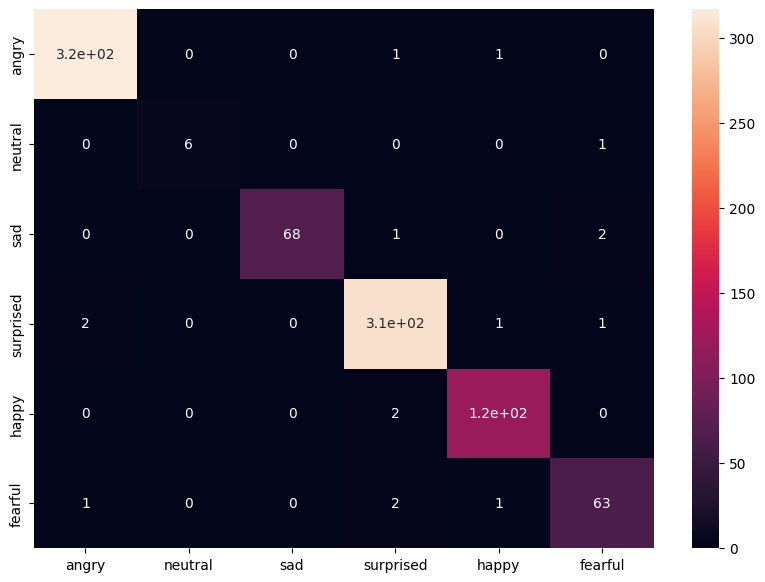

In [ ]:
confusion_emotions = ['angry','neutral', 'sad','surprised','happy','fearful']
cm=metrics.confusion_matrix(y_test,np.argmax(y_pred,axis=-1))
df_cm=pd.DataFrame(cm,index=[i for i in confusion_emotions],columns=[i for i in confusion_emotions])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm,annot=True)

In [ ]:
if not os.path.exists('SER/model'):
    os.makedirs('SER/model')

model.save("SER/model/cnn.h5")

In [ ]:
input_emotion = 'sadness'
input_encoded = np.zeros((1, len(emotions), 1))
input_encoded[0, emotions.index(input_emotion), 0] = 1

output_probs = model.predict(input_encoded)[0]
sorted_indices = np.argsort(output_probs)[::-1]
suggested_indices = sorted_indices[:3]

suggested_suggestions = [list(vocab)[i] for i in suggested_indices]
print("Suggestions for", input_emotion, ":", suggested_suggestions)

1/1 [==============================] - 0s 34ms/step
Suggestions for sadness : ['Engage in a hobby', 'Take deep breaths', 'Write in a journal']


In [ ]:
df.head()

,Unnamed: 0,persian,mood,sentence
0,0,بیرون قدم بزن,angry,Take a walk outside
1,1,یک نفس عمیق بکش,angry,Take a deep breath
2,2,یک تکنیک مدیتیشن را امتحان کنید,angry,Try a meditation technique
3,3,به رختخواب بروید و استراحت کنید,angry,Go to bed and relax
4,4,دوش بگیرید و استراحت کنید,angry,Get a shower and relax
